## Run, Dont Read

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch as t
from torch import Tensor
from torch.nn import functional as F
from jaxtyping import Float, Int, Bool
from tqdm import tqdm
import copy
from transformer_lens import utils, ActivationCache
from transformer_lens.hook_points import HookPoint
from typing import List, Optional, Callable, Tuple, Dict, Literal, Set, Union        
import argparse
#import wandb
#################################################
from Patching.ActivationPatching import ActivationPatching
from Patching.PathPatching import PathPatching
from utils.Visualization import *
#from Patching.ACDC import ACDC
import gc
from IPython import get_ipython
from transformers import AutoModelForCausalLM, AutoTokenizer

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib.pyplot import imshow

from dataset.loader import load_dataset
from utils.PatchingMetric import ave_logit_diff
from utils.eval_circuit import *
from utils.Visualization import outline_IoU, outline_IOI, heat_map_sparsity
from utils.model_loader import load_tokenizer, load_hooked_transformer,load_transformer
from utils.dataset_loader import predict_target_token
from utils.utils import create_folder, activation_patterns, save_circuit, save_circuit, load_circuit, save_dict


from circuits_PP import *
from Patching.parser import parser
from Patching.automated_PP import automated_PP

ipython = get_ipython()
is_notebook =  ipython is not None

print("running as notebook: ", is_notebook)
t.autograd.set_grad_enabled(False)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


running as notebook:  True


## Add Arguments

In [4]:
is_notebook = get_ipython()
ipython =  is_notebook is not None

if is_notebook:
    # TODO: remove q,v,k
    input_args = [
        #
        #"--task=induction",
        "--task=GreaterThan",
        #"--task=GenderedPronouns",
        #"--task=ioi",
        #"--task=Docstring",
        #"--patching_method=path",
        "--N=100",
        "--metric=logits_diff",
        "--mode=sqrt",

        #"--model_name=gpt2",
        #"--model_name=gpt2-large",
        "--model_name=Qwen/Qwen2.5-0.5B",
        "--device=cuda",
        "--out_path=/mnt/lustre/work/eickhoff/esx670/res_final/",
        "--cache_dir=/mnt/lustre/work/eickhoff/esx670/llm_weights",
        "--seed=12345432",
        "--calc_FLOPS", 
        "--show",
        #"--verbose" ,
        "--save_every_x_steps=100", 
        #"--save_text", 
        #"--save_img"
    ]
    
    
    args = parser.parse_args(input_args)
else:
    args = parser.parse_args()
    
    
# No Circuit:
PRUNING_CIRCUIT = None

# gpt large 

#PRUNING_CIRCUIT = load_circuit("/mnt/lustre/work/eickhoff/esx670/res/gpt2-large/ioi/Hybrid-FLAP/sparsity-min_55/sparsity-max_95/step-size_5", name="hybrid_circuit.txt")

# gpt small:
#PRUNING_CIRCUIT = load_circuit("/mnt/lustre/work/eickhoff/esx670/res/gpt2-small/ioi/Hybrid-FLAP/sparsity-min_55/sparsity-max_95/step-size_5", name="hybrid_circuit.txt")

    
if args.mode=="sqrt":
    if PRUNING_CIRCUIT is None:
        result_folder = f"{args.model_name}/{args.task}/{args.patching_method}/automatic/{args.metric}/{args.mode}/min_threshold-{args.min_activation_threshold}/k_{args.k}-scale_{args.scale}"
    else:
        result_folder = f"{args.model_name}/{args.task}/FLAP_Path_Patching/{args.metric}/{args.mode}/min_threshold-{args.min_activation_threshold}/k_{args.k}-scale_{args.scale}"
else:
    if PRUNING_CIRCUIT is None:
        result_folder = f"{args.model_name}/{args.task}/{args.patching_method}/automatic/{args.metric}/{args.mode}/min_threshold-{args.min_activation_threshold}/alpha_{args.alpha}-scale_{args.scale}"
    else:
        result_folder = f"{args.model_name}/{args.task}/FLAP_Path_Patching/{args.metric}/{args.mode}/min_threshold-{args.min_activation_threshold}/alpha_{args.alpha}-scale_{args.scale}"



if args.out_path == "":
    subfolder = result_folder
else:
    subfolder = os.path.join(args.out_path, result_folder)

create_folder(subfolder)  

from utils.config import set_PATH
set_PATH(args.out_path)

## Activation Patching, Path Patching, ACDC to ONE specifif head

In [46]:

receiver_heads = []
PRUNING_CIRCUIT = None

if args.patching_method == "activation":
    ap = ActivationPatching(
        model_name=args.model_name, 
        task=args.task, 
        patching_method=args.patching_method, 
        metric_name=args.metric, 
        N=args.N, 
        device=args.device, 
        seed=args.seed, )
elif args.patching_method == "path":
    pp = PathPatching(
        model_name=args.model_name, 
        task=args.task, 
        patching_method=args.patching_method, 
        metric_name=args.metric, 
        N=args.N, 
        device=args.device, 
        patch_mlp=args.patch_mlp,
        seed=args.seed, 
        cache_dir=args.cache_dir
    )


loading gpt2 as HookedTransformer
use float 16
Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cuda
load gpt2 tokenizer
Load GreaterThan with gpt2
FLOP per forwad <fvcore.nn.flop_count.FlopCountAnalysis object at 0x7efcd4695a50>


blocks.0.attn.hook_attn_scores, blocks.0.attn.hook_k, blocks.0.attn.hook_pattern, blocks.0.attn.hook_q, blocks.0.attn.hook_result, blocks.0.attn.hook_v, blocks.0.attn.hook_z, blocks.0.hook_attn_in, blocks.0.hook_attn_out, blocks.0.hook_k_input, blocks.0.hook_mlp_in, blocks.0.hook_mlp_out, blocks.0.hook_q_input, blocks.0.hook_resid_mid, blocks.0.hook_resid_post, blocks.0.hook_resid_pre, blocks.0.hook_v_input, blocks.0.ln1.hook_normalized, blocks.0.ln1.hook_scale, blocks.0.ln2.hook_normalized, blocks.0.ln2.hook_scale, blocks.0.mlp.hook_post, blocks.0.mlp.hook_pre, blocks.1.attn.hook_attn_scores, blocks.1.attn.hook_k, blocks.1.attn.hook_pattern, blocks.1.attn.hook_q, blocks.1.attn.hook_result, blocks.1.attn.hook_v, blocks.1.attn.hook_z, blocks.1.hook_attn_in, blocks.1.hook_attn_out, blocks.1.hook_k_input, blocks.1.hook_mlp_in, blocks.1.hook_mlp_out, blocks.1.hook_q_input, blocks.1.hook_resid_mid, blocks.1.hook_resid_post, blocks.1.hook_resid_pre, blocks.1.hook_v_input, blocks.1.ln1.hook_n

In [57]:
receiver_heads = [(5,1)]

done cleaning


 ... (more hidden) ...


number of FLOPS: 0.00 GFLOPs
total number of Forward Passes: 1034


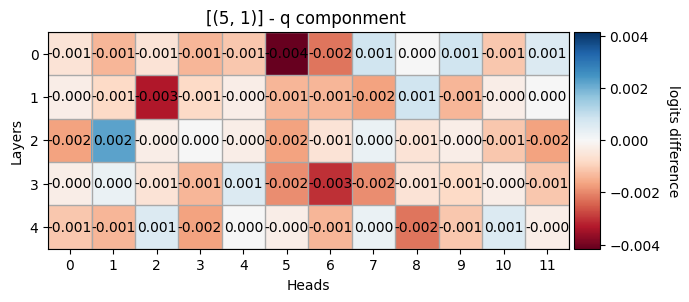

 ... (more hidden) ...


number of FLOPS: 0.00 GFLOPs
total number of Forward Passes: 1094


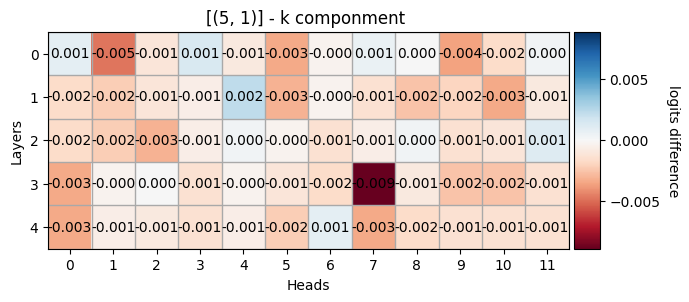

 ... (more hidden) ...


number of FLOPS: 0.00 GFLOPs
total number of Forward Passes: 1154


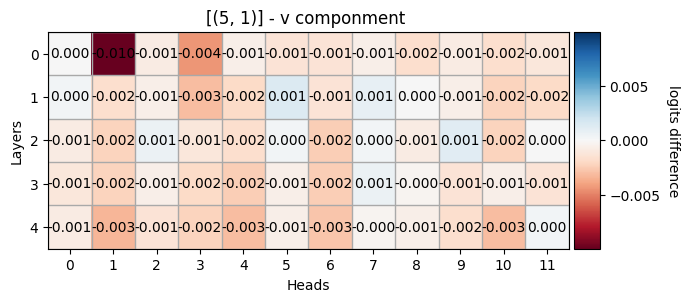

In [58]:

result_folder = f"{args.model_name}/{args.task}/{args.patching_method}/automatic/"

if args.out_path == "":
    subfolder = result_folder
else:
    subfolder = os.path.join(args.out_path, result_folder)

pp.create_folder(subfolder)

save_all=True

if args.metric == "logits_diff":
    color_axis_title = "logits difference"
elif args.metric == "probs":
    color_axis_title = "probability difference"
else:
    color_axis_title = "KL Divergence"

if args.save_img:
    print("save at", subfolder)

# Save some mem
gc.collect()
#t.cuda.empty_cache()
print("done cleaning")

if args.patching_method == "activation":
    name = f"{args.model_name}_{args.metric}_resid_post"
    
    if args.per_position:
        title="activation patching per position"
        labels = ap.tok_to_labels(ap.dataset.clean_tokens[0])
        result = ap.act_patch_per_position_per_componment()
        heat_map_layer_pos(result, title, color_axis_title, show=args.show, save=args.save_img, name=name, subfolder=subfolder, labels = labels)    
    
    else:
        title="activation patchimg"
        result = ap.get_act_patch_attn_head_out_all_pos()
        heat_map_layer_head(result, title, color_axis_title, show=args.show, save=args.save_img, subfolder=subfolder, name=name)
        
        
elif args.patching_method == "path":
    
    if args.save_img and not "manual" in subfolder:
        subfolder = subfolder + "/manual"
    
    if len(receiver_heads) == 0:
        title="path patchign resid post"
        name = f"{args.model_name}_{args.metric}_resid_post"
        result = pp.get_path_patch_head_to_final_resid_post(
            corrupted_cache=pp.corrupted_cache,
            clean_cache=pp.clean_cache, 
            PRUNING_CIRCUIT=PRUNING_CIRCUIT
            )
        print(f"number of FLOPS: {pp.FLOP_counter/ 1e9:.2f} GFLOPs")
        print("total number of Forward Passes:", pp.n_forward_passes)

        heat_map_layer_head(result, "path patching - resid post", color_axis_title, show=args.show, save=args.save_img, subfolder=subfolder, name=name)
    
    else:     
        for receiver_input in "qkv":
            title = f"{receiver_heads} - {receiver_input} componment "
            name = f"{args.model_name}_{args.metric}_{receiver_heads}_{receiver_input}"
            if "Qwen" in args.model_name:    
                result = pp.patch_whole_graph_qwen(
                    receiver_head = receiver_heads,
                    receiver_input = receiver_input,
                    corrupted_cache = pp.corrupted_cache,
                    clean_cache = pp.clean_cache,
                    PRUNING_CIRCUIT=PRUNING_CIRCUIT
                )
            else:
                result = pp.get_path_patch_head_to_heads(
                    receiver_heads=receiver_heads, 
                    receiver_input=receiver_input,
                    corrupted_cache=pp.corrupted_cache,
                    clean_cache=pp.clean_cache, 
                    PRUNING_CIRCUIT=PRUNING_CIRCUIT
                )
                
            print(f"number of FLOPS: {pp.FLOP_counter/ 1e9:.2f} GFLOPs")
            print("total number of Forward Passes:", pp.n_forward_passes)
            heat_map_layer_head(
                result,
                title=title,
                color_axis_title=color_axis_title, 
                show=args.show,
                save=args.save_img,
                subfolder=subfolder + "/heatmap", 
                name=name,
                print_vals=True,
            ) 
            
            
    
 
    
elif args.patching_method == "acdc":
    acdc = ACDC(
    model_name=args.model_name,
    task=args.task,
    patching_method=args.patching_method,
    metric_name=args.metric_name,
    N=args.N,
    threshold=args.threshold,
    remove_redundant=args.remove_redunant,
    verbose=args.verbose,
    single_step=False,
    early_stop=False,
    corrupted_cache_cpu=args.corrupted_cache_cpu,
    online_cache_cpu =args.online_cache_cpu,
    seed=args.seed,
    indices_mode="reverse",
    names_mode="normal",
    zero_ablation=args.zero_ablation,
    device=args.device,
    abs_value_threshold=args.bs_value_threshold,
    out_path=subfolder
    )
    
    if args.reset_network:
        acdc.reset_network()

    
    acdc.run_exp(testing=False, max_epochs=100000)
    
    if save_all:
        acdc.save_subgraph_long(subfolder)

## Automatic Path Patching

load Qwen tokenizer
loading Qwen/Qwen2.5-0.5B as HookedTransformer
use float 16
Loaded pretrained model Qwen/Qwen2.5-0.5B into HookedTransformer
Moving model to device:  cuda
loading GreaterThan dataset for Qwen/Qwen2.5-0.5B
test that the right token is predicted by the unpruned model under clean distribution
Top 10 Predictions
Prompt 0 : The test lasted from the year 1615 to the year 1672
1          | Probability: 0.3105
2          | Probability: 0.2345
3          | Probability: 0.1400
4          | Probability: 0.0836
6          | Probability: 0.0641
5          | Probability: 0.0631
7          | Probability: 0.0469
8          | Probability: 0.0333
9          | Probability: 0.0215
0          | Probability: 0.0010


test that the right token is predicted by the unpruned model under corrupted distribution
Top 10 Predictions
Prompt 0 : The test lasted from the year 1601 to the year 1672
0          | Probability: 0.3369
1          | Probability: 0.1592
3          | Probability: 0.1077
2   

blocks.0.attn.hook_attn_scores, blocks.0.attn.hook_k, blocks.0.attn.hook_pattern, blocks.0.attn.hook_q, blocks.0.attn.hook_result, blocks.0.attn.hook_rot_k, blocks.0.attn.hook_rot_q, blocks.0.attn.hook_v, blocks.0.attn.hook_z, blocks.0.hook_attn_in, blocks.0.hook_attn_out, blocks.0.hook_k_input, blocks.0.hook_mlp_in, blocks.0.hook_mlp_out, blocks.0.hook_q_input, blocks.0.hook_resid_mid, blocks.0.hook_resid_post, blocks.0.hook_resid_pre, blocks.0.hook_v_input, blocks.0.ln1.hook_normalized, blocks.0.ln1.hook_scale, blocks.0.ln2.hook_normalized, blocks.0.ln2.hook_scale, blocks.0.mlp.hook_post, blocks.0.mlp.hook_pre, blocks.0.mlp.hook_pre_linear, blocks.1.attn.hook_attn_scores, blocks.1.attn.hook_k, blocks.1.attn.hook_pattern, blocks.1.attn.hook_q, blocks.1.attn.hook_result, blocks.1.attn.hook_rot_k, blocks.1.attn.hook_rot_q, blocks.1.attn.hook_v, blocks.1.attn.hook_z, blocks.1.hook_attn_in, blocks.1.hook_attn_out, blocks.1.hook_k_input, blocks.1.hook_mlp_in, blocks.1.hook_mlp_out, blocks.

Average logit difference original model:  4.250468730926514
result Qwen/Qwen2.5-0.5B/GreaterThan/path/automatic/logits_diff/sqrt/min_threshold-0.002/k_2-scale_2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 336/336 [00:30<00:00, 11.13it/s]


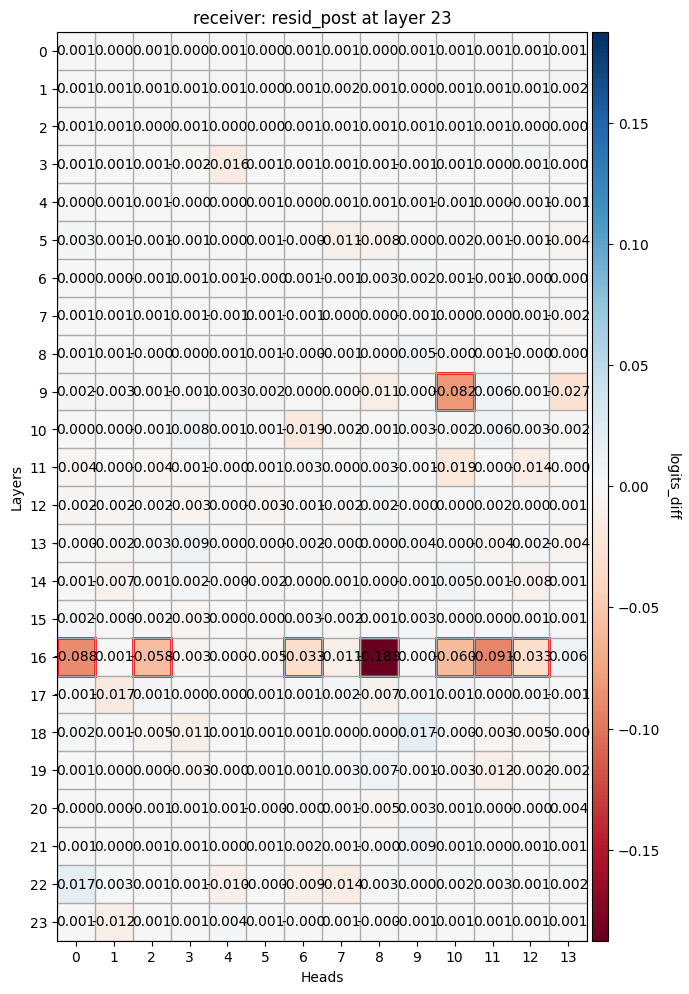

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:16<00:00,  7.66it/s]


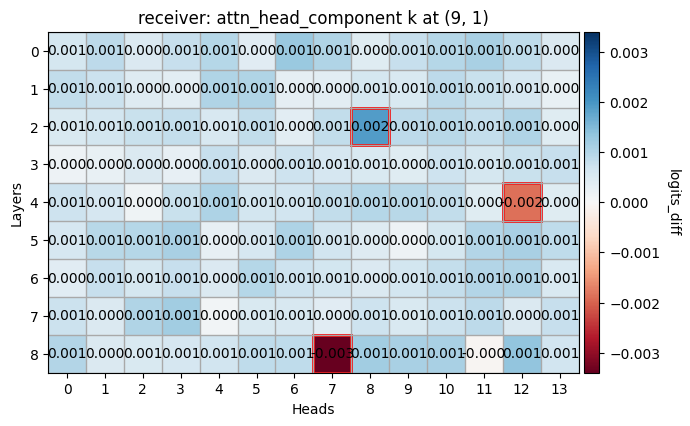

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 224/224 [00:29<00:00,  7.61it/s]
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


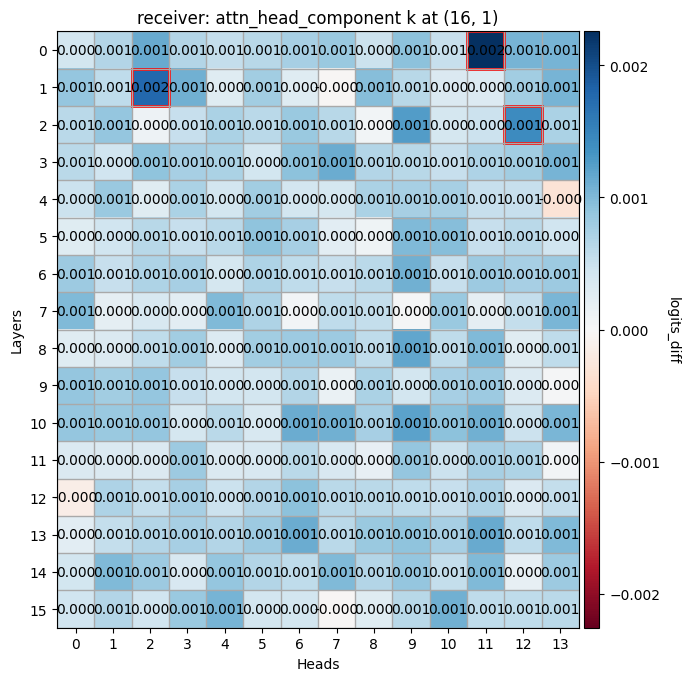

 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


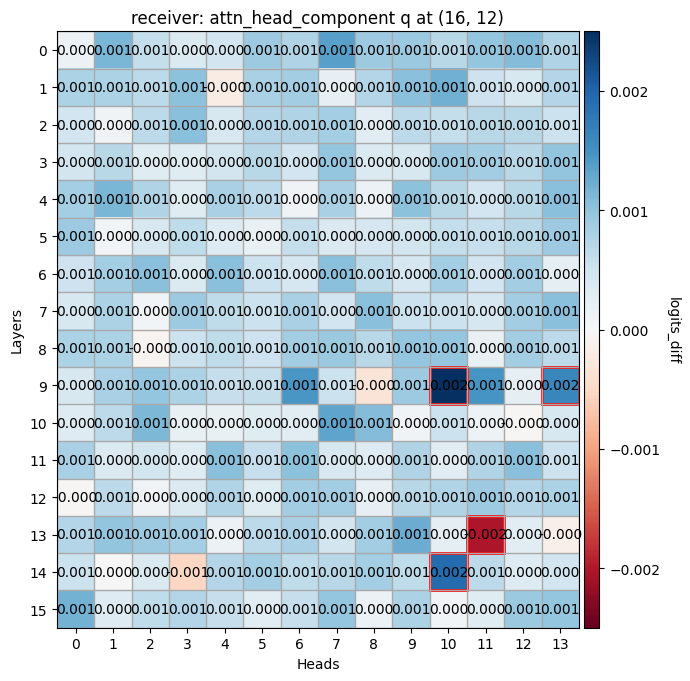

 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


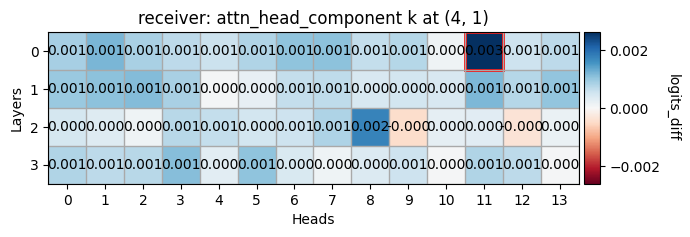

 ... (more hidden) ...
 ... (more hidden) ...


skipt zero layers (0, 11)


 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


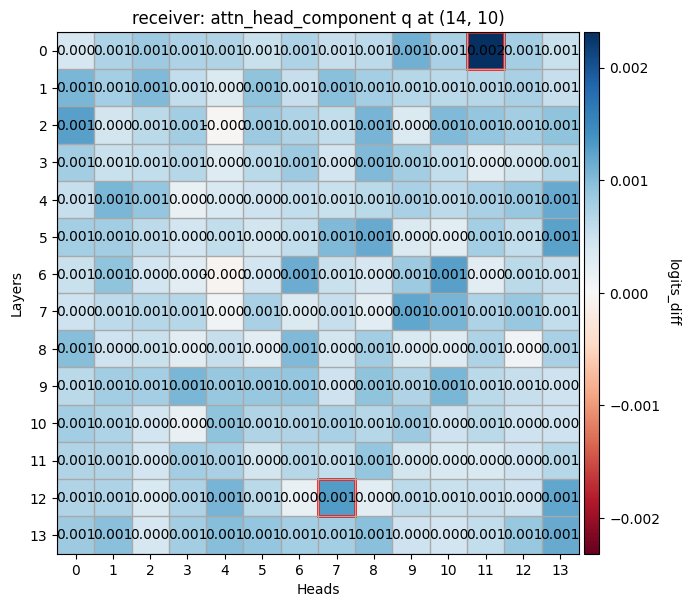

 ... (more hidden) ...


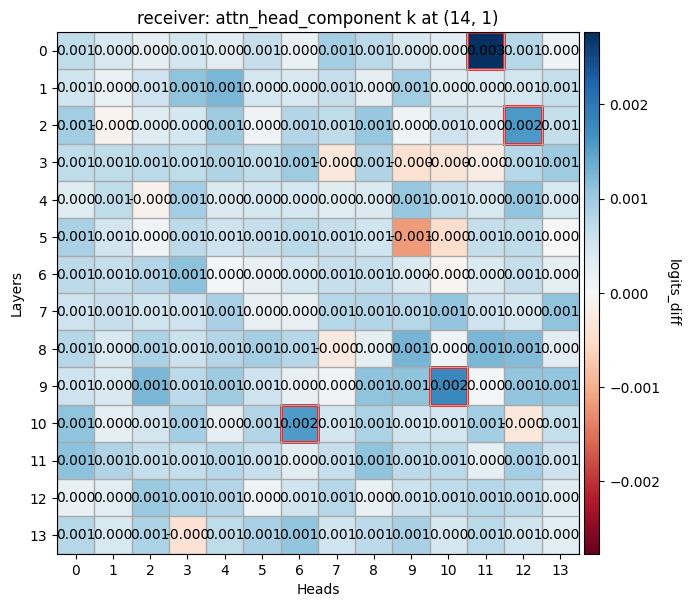

skipt zero layers (0, 11)


 ... (more hidden) ...
 ... (more hidden) ...


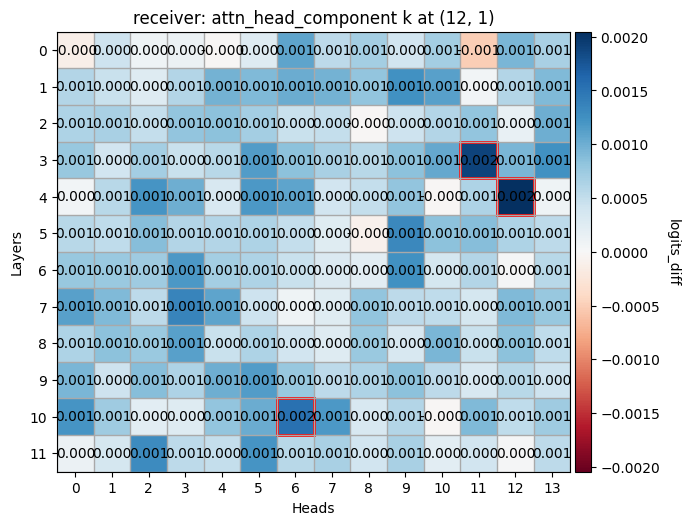

 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


{9: [10, 13],
 16: [0, 2, 6, 8, 10, 11, 12],
 2: [8, 12],
 4: [12],
 8: [7],
 0: [11],
 1: [2],
 13: [11],
 14: [10],
 12: [7],
 10: [6],
 3: [11]}

In [4]:
#min_activation_thresholds = [0.0005]#, 0.0002] # good for gpt2-large
#min_activation_thresholds=[0.002, 0.001, 0.01, 0.02]
#min_activation_thresholds=[0.005, 0.002, 0.001]

#min_activation_thresholds=[0.01, 0.001, 0.02, 0.002]
#min_activation_thresholds = [ 0.001, 0.005, 0.0001, 0.0005]  # Qwen Greaterthan
#min_activation_thresholds = [0.01, 0.05, 0.001, 0.005]
#ks = [2, 3, 4, 5]
#scales = [1.5, 2.0, 2.5]
scales = [2]
min_activation_thresholds=[0.002]
ks = [2]

#scales = [2]
CIRCUIT = automated_PP(     
    args=args,
    ks = [2], 
    scales = scales,
    min_activation_thresholds=min_activation_thresholds,
    resid_scale=2
    )
CIRCUIT

In [6]:
CIRCUIT = {9: [10, 13],
 16: [0, 2, 6, 8, 10, 11, 12],
 2: [8, 12],
 4: [12],
 8: [7],
 0: [11],
 1: [2],
 13: [11],
 14: [10],
 12: [7],
 10: [6],
 3: [11]}

### Evaluate

In [7]:
#----- Load tokenizer and model ------
eval_tokenizer = load_tokenizer(args.model_name)
model_hooked = load_hooked_transformer(args.model_name, cache_dir=args.cache_dir)
eval_dataset = load_dataset(
    prepend_bos=args.prepend_bos,
    task=args.task, 
    patching_method="path",
    tokenizer=eval_tokenizer, 
    N=200, 
    device=args.device,
    model_name=args.model_name,
    seed=args.seed+100
    )


# ----- Test that the correct prediction is made -----
predict_target_token(model_hooked, eval_dataset, eval_tokenizer, device=args.device, n=1)


# ----- Average Logit Difference of the unpatched Model -----
with torch.no_grad():
    logits_gt = model_hooked(eval_dataset.clean_tokens)
ave_logit_gt = ave_logit_diff(
    logits=logits_gt, 
    correct_answers=eval_dataset.correct_answers,
    wrong_answers=eval_dataset.wrong_answers,
    target_idx=eval_dataset.target_idx.to(args.device),
    task=args.task,
    model_name=args.model_name
    )
print("Average logit difference original model: ", ave_logit_gt)


load Qwen tokenizer
loading Qwen/Qwen2.5-0.5B as HookedTransformer
use float 16
Loaded pretrained model Qwen/Qwen2.5-0.5B into HookedTransformer
Moving model to device:  cuda
loading GreaterThan dataset for Qwen/Qwen2.5-0.5B
Top 10 Predictions
Prompt 0 : The test lasted from the year 1767 to the year 1790
6          | Probability: 0.4473
7          | Probability: 0.3428
8          | Probability: 0.1241
9          | Probability: 0.0801
5          | Probability: 0.0020
4          | Probability: 0.0006
1          | Probability: 0.0005
2          | Probability: 0.0005
3          | Probability: 0.0004
0          | Probability: 0.0004


Average logit difference original model:  4.117812633514404


In [8]:
ave_logit, performance = evaluate_circiut(
    model = model_hooked, 
    CIRCUIT=CIRCUIT,
    dataset=eval_dataset,
    ave_logit_gt=ave_logit_gt,
    task=args.task,
    model_name=args.model_name
    )

result_text = print_statics(
    title=f"*********** {args.task} CIRCUIT**************",
    ave_logit=ave_logit, 
    performance_achieved=performance,
    CIRCUIT=CIRCUIT, 
    IOI_CIRCUIT=CIRCUIT
    )
 
print(result_text)


 
*********** GreaterThan CIRCUIT**************
Average logit difference: 3.1063 
circuit size: 20 
performance achieved: 75.44% 
TPR: 100.00% 
FPR: 0.00% 
Precision: 100.00% 



In [9]:
batch_size=25
epochs = int(args.N /batch_size)

ave_logit, performance = batch_evaluate_circiut(
    model = model_hooked, 
    CIRCUIT=CIRCUIT,
    dataset=eval_dataset,
    ave_logit_gt=ave_logit_gt,
    task=args.task,
    model_name=args.model_name, 
    epochs = epochs, 
    batch_size = batch_size 
    )

result_text = print_statics(
    title="*********** IOI CIRCUIT WITHOUT BACKUP HEADS**************",
    ave_logit=ave_logit, 
    performance_achieved=performance,
    CIRCUIT=CIRCUIT, 
    IOI_CIRCUIT=CIRCUIT
    )
 
print(result_text)


 
*********** IOI CIRCUIT WITHOUT BACKUP HEADS**************
Average logit difference: 3.2400 
circuit size: 20 
performance achieved: 78.68% 
TPR: 100.00% 
FPR: 0.00% 
Precision: 100.00% 



## Accelerated Path Patching

Namespace(model_name='Qwen/Qwen2.5-0.5B', task='GreaterThan', metric='logits_diff', cache_dir='/mnt/lustre/work/eickhoff/esx670/llm_weights', out_path='/mnt/lustre/work/eickhoff/esx670/res_final/', device='cuda', N=100, prepend_bos=False, seed=12345432, per_position=False, patch_mlp=False, patching_method='path', alpha=0.5, mode='sqrt', scale=1.75, k=2, use_old_input=False, save_every_x_steps=100, min_activation_threshold=0.002, show=True, save_img=False, save_text=False, verbose=False, calc_FLOPS=True, threshold=0.35, zero_ablation=False, remove_redundant=False, reset_network=False, online_cache_cpu=False, corrupted_cache_cpu=False, abs_value_threshold=False)
/mnt/lustre/work/eickhoff/esx670/res_final//Qwen/Qwen2.5-0.5B/GreaterThan/Hybrid-FLAP/first/sparsity-min_60/sparsity-max_99/


load Qwen tokenizer
loading Qwen/Qwen2.5-0.5B as HookedTransformer
use float 16
Loaded pretrained model Qwen/Qwen2.5-0.5B into HookedTransformer
Moving model to device:  cuda
loading GreaterThan dataset for Qwen/Qwen2.5-0.5B
Top 10 Predictions
Prompt 0 : The test lasted from the year 1615 to the year 1672
1          | Probability: 0.3105
2          | Probability: 0.2345
3          | Probability: 0.1400
4          | Probability: 0.0836
6          | Probability: 0.0641
5          | Probability: 0.0631
7          | Probability: 0.0469
8          | Probability: 0.0333
9          | Probability: 0.0215
0          | Probability: 0.0010


loading GreaterThan dataset for Qwen/Qwen2.5-0.5B
FLOP per forwad <fvcore.nn.flop_count.FlopCountAnalysis object at 0x7f82c56697d0>


blocks.0.attn.hook_attn_scores, blocks.0.attn.hook_k, blocks.0.attn.hook_pattern, blocks.0.attn.hook_q, blocks.0.attn.hook_result, blocks.0.attn.hook_rot_k, blocks.0.attn.hook_rot_q, blocks.0.attn.hook_v, blocks.0.attn.hook_z, blocks.0.hook_attn_in, blocks.0.hook_attn_out, blocks.0.hook_k_input, blocks.0.hook_mlp_in, blocks.0.hook_mlp_out, blocks.0.hook_q_input, blocks.0.hook_resid_mid, blocks.0.hook_resid_post, blocks.0.hook_resid_pre, blocks.0.hook_v_input, blocks.0.ln1.hook_normalized, blocks.0.ln1.hook_scale, blocks.0.ln2.hook_normalized, blocks.0.ln2.hook_scale, blocks.0.mlp.hook_post, blocks.0.mlp.hook_pre, blocks.0.mlp.hook_pre_linear, blocks.1.attn.hook_attn_scores, blocks.1.attn.hook_k, blocks.1.attn.hook_pattern, blocks.1.attn.hook_q, blocks.1.attn.hook_result, blocks.1.attn.hook_rot_k, blocks.1.attn.hook_rot_q, blocks.1.attn.hook_v, blocks.1.attn.hook_z, blocks.1.hook_attn_in, blocks.1.hook_attn_out, blocks.1.hook_k_input, blocks.1.hook_mlp_in, blocks.1.hook_mlp_out, blocks.

Average logit difference original model:  4.250468730926514
result Qwen/Qwen2.5-0.5B/GreaterThan/APP/min_threshold-0.002/scale-2


 ... (more hidden) ...


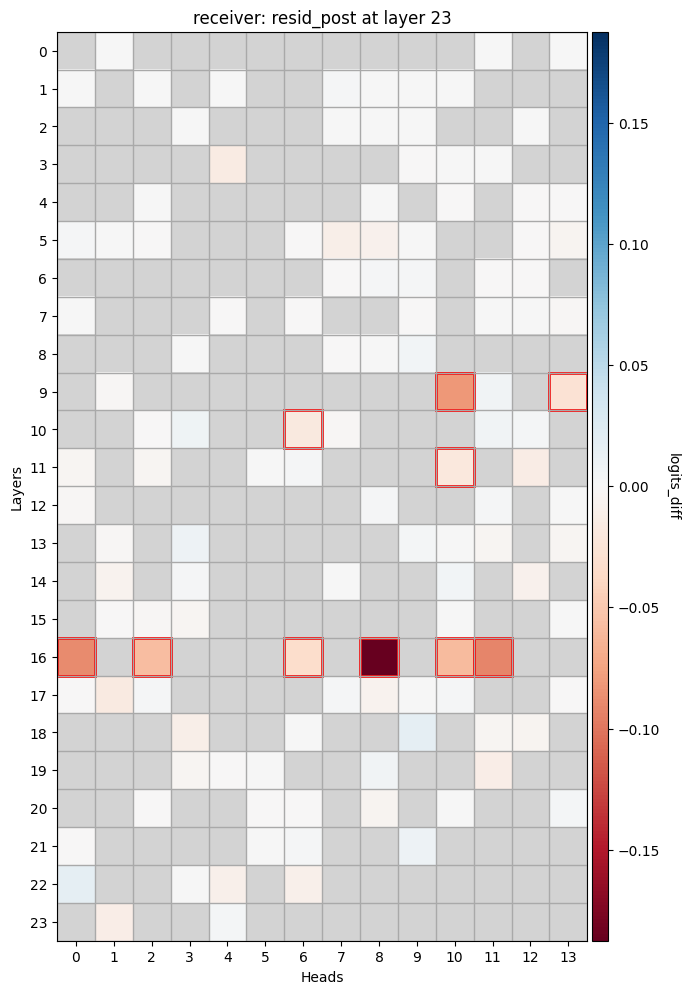

 ... (more hidden) ...
 ... (more hidden) ...


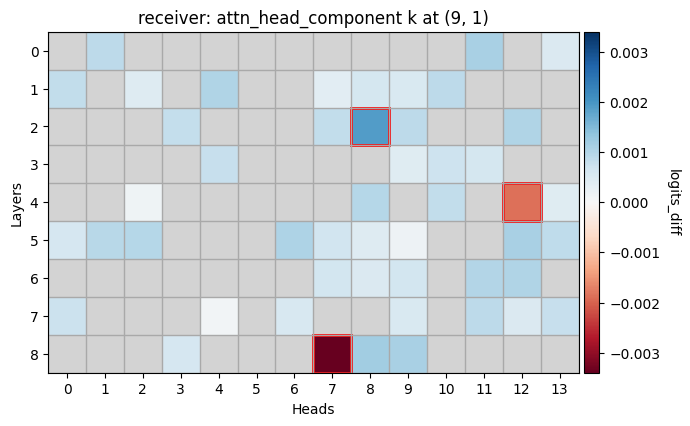

 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


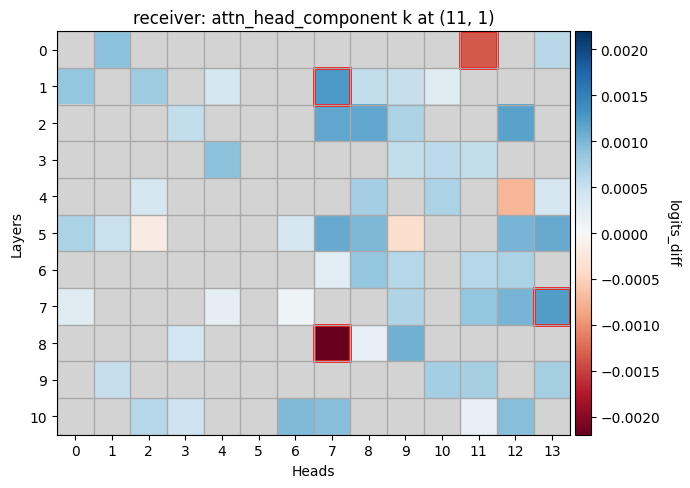

 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


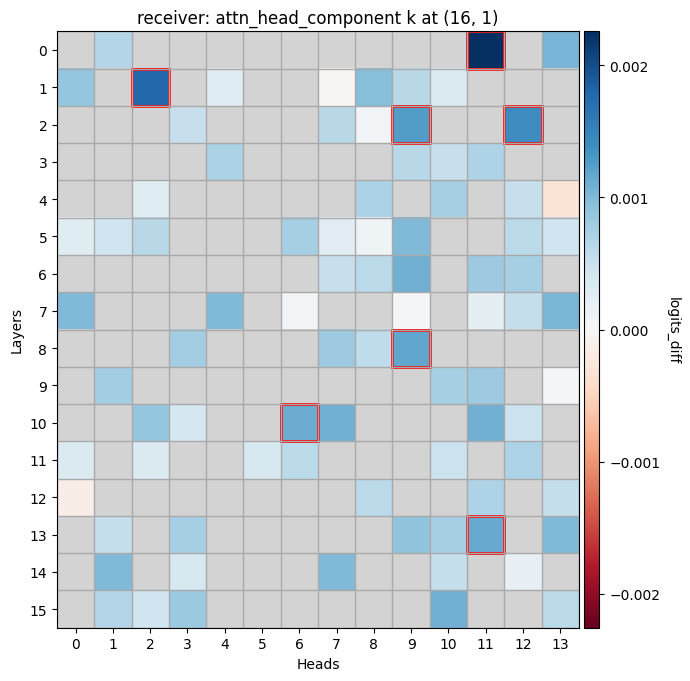

 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


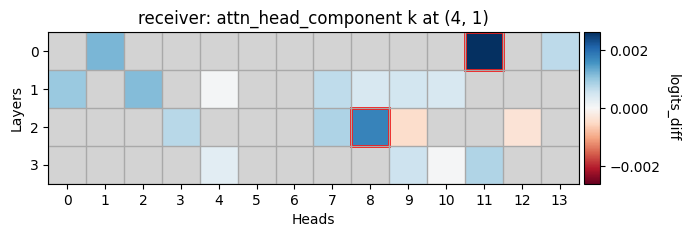

 ... (more hidden) ...
 ... (more hidden) ...


skipt zero layers (0, 11)


 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


In [16]:
from Patching.FLAP_Patching import FLAP_patching
gc.collect()
t.cuda.empty_cache()

#scales = [2.5, 2, 1.5, 1]
scales=[2]
min_activation_thresholds=[0.002]
ks = [1]
#scales = [2]

APP_CIRCUIT = FLAP_patching(     
    args=args,
    ks = ks, 
    scales = scales,
    min_activation_thresholds=min_activation_thresholds, 
    resid_scale=1
)


In [19]:
CIRCUIT 

{5: [5], 6: [9], 7: [10], 8: [8, 11], 9: [1], 0: [1, 5]}

In [25]:
APP_CIRCUIT

{5: [5, 1], 6: [9], 7: [10], 9: [1], 0: [1]}

### Evaluate

In [9]:

#----- Load tokenizer and model ------
eval_tokenizer = load_tokenizer(args.model_name)
model_hooked = load_hooked_transformer(args.model_name, device=args.device, cache_dir=args.cache_dir)
eval_dataset = load_dataset(
    prepend_bos=args.prepend_bos,
    task=args.task, 
    patching_method="path",
    tokenizer=eval_tokenizer, 
    N=200, 
    device=args.device,
    model_name=args.model_name,
    seed=args.seed+20
    )


# ----- Test that the correct prediction is made -----
predict_target_token(model_hooked, eval_dataset, eval_tokenizer, device=args.device, n=1)


# ----- Average Logit Difference of the unpatched Model -----
with torch.no_grad():
    logits_gt = model_hooked(eval_dataset.clean_tokens)
ave_logit_gt = ave_logit_diff(
    logits=logits_gt, 
    correct_answers=eval_dataset.correct_answers, 
    wrong_answers=eval_dataset.wrong_answers,
    target_idx=eval_dataset.target_idx.to(args.device),
    task=args.task,
    model_name=args.model_name
    )
print("Average logit difference original model: ", ave_logit_gt)


load gpt2 tokenizer
loading gpt2 as HookedTransformer
use float 16
Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cuda
Load GreaterThan with gpt2
Top 10 Predictions
Prompt 0 : The test lasted from the year 1615 to the year 1676
20         | Probability: 0.1610
60         | Probability: 0.0671
30         | Probability: 0.0671
18         | Probability: 0.0522
50         | Probability: 0.0522
40         | Probability: 0.0461
25         | Probability: 0.0317
16         | Probability: 0.0280
19         | Probability: 0.0247
17         | Probability: 0.0247


Average logit difference original model:  3.3418750762939453


In [21]:
ave_logit, performance = evaluate_circiut(
    model = model_hooked, 
    CIRCUIT=CIRCUIT,
    dataset=eval_dataset,
    ave_logit_gt=ave_logit_gt,
    task=args.task,
    model_name=args.model_name
    )

result_text = print_statics(
    title=f"*********** PP circuit for {args.task} on model {args.model_name}**************",
    ave_logit=ave_logit, 
    performance_achieved=performance,
    CIRCUIT=CIRCUIT, 
    IOI_CIRCUIT=CIRCUIT
    )
 
print(result_text)


 
*********** PP circuit for GreaterThan on model gpt2**************
Average logit difference: 2.6363 
circuit size: 8 
performance achieved: 78.89% 
TPR: 100.00% 
FPR: 0.00% 
Precision: 100.00% 



In [22]:

ave_logit, performance = evaluate_circiut(
    model = model_hooked, 
    CIRCUIT=APP_CIRCUIT,
    dataset=eval_dataset,
    ave_logit_gt=ave_logit_gt,
    task=args.task,
    model_name=args.model_name
    )

result_text = print_statics(
    title=f"*********** APP circuit for {args.task} on model {args.model_name}**************",
    ave_logit=ave_logit, 
    performance_achieved=performance,
    CIRCUIT=APP_CIRCUIT, 
    IOI_CIRCUIT=CIRCUIT
    )
 
print(result_text)


 
*********** APP circuit for GreaterThan on model gpt2**************
Average logit difference: 2.1637 
circuit size: 7 
performance achieved: 64.75% 
TPR: 75.00% 
FPR: 14.29% 
Precision: 85.71% 



## Contrastive APP

Namespace(model_name='Qwen/Qwen2.5-0.5B', task='GreaterThan', metric='logits_diff', cache_dir='/mnt/lustre/work/eickhoff/esx670/llm_weights', out_path='/mnt/lustre/work/eickhoff/esx670/res_final/', device='cuda', N=100, prepend_bos=False, seed=12345432, per_position=False, patch_mlp=False, patching_method='path', alpha=0.5, mode='sqrt', scale=1.5, k=2, use_old_input=False, save_every_x_steps=100, min_activation_threshold=0.002, show=True, save_img=False, save_text=False, verbose=False, calc_FLOPS=True, threshold=0.35, zero_ablation=False, remove_redundant=False, reset_network=False, online_cache_cpu=False, corrupted_cache_cpu=False, abs_value_threshold=False)


load Qwen tokenizer
loading Qwen/Qwen2.5-0.5B as HookedTransformer
use float 16
Loaded pretrained model Qwen/Qwen2.5-0.5B into HookedTransformer
Moving model to device:  cuda
loading GreaterThan dataset for Qwen/Qwen2.5-0.5B
Top 10 Predictions
Prompt 0 : The test lasted from the year 1615 to the year 1672
1          | Probability: 0.3105
2          | Probability: 0.2345
3          | Probability: 0.1400
4          | Probability: 0.0836
6          | Probability: 0.0641
5          | Probability: 0.0631
7          | Probability: 0.0469
8          | Probability: 0.0333
9          | Probability: 0.0215
0          | Probability: 0.0010


loading GreaterThan dataset for Qwen/Qwen2.5-0.5B
FLOP per forwad <fvcore.nn.flop_count.FlopCountAnalysis object at 0x7f82c071c810>


blocks.0.attn.hook_attn_scores, blocks.0.attn.hook_k, blocks.0.attn.hook_pattern, blocks.0.attn.hook_q, blocks.0.attn.hook_result, blocks.0.attn.hook_rot_k, blocks.0.attn.hook_rot_q, blocks.0.attn.hook_v, blocks.0.attn.hook_z, blocks.0.hook_attn_in, blocks.0.hook_attn_out, blocks.0.hook_k_input, blocks.0.hook_mlp_in, blocks.0.hook_mlp_out, blocks.0.hook_q_input, blocks.0.hook_resid_mid, blocks.0.hook_resid_post, blocks.0.hook_resid_pre, blocks.0.hook_v_input, blocks.0.ln1.hook_normalized, blocks.0.ln1.hook_scale, blocks.0.ln2.hook_normalized, blocks.0.ln2.hook_scale, blocks.0.mlp.hook_post, blocks.0.mlp.hook_pre, blocks.0.mlp.hook_pre_linear, blocks.1.attn.hook_attn_scores, blocks.1.attn.hook_k, blocks.1.attn.hook_pattern, blocks.1.attn.hook_q, blocks.1.attn.hook_result, blocks.1.attn.hook_rot_k, blocks.1.attn.hook_rot_q, blocks.1.attn.hook_v, blocks.1.attn.hook_z, blocks.1.hook_attn_in, blocks.1.hook_attn_out, blocks.1.hook_k_input, blocks.1.hook_mlp_in, blocks.1.hook_mlp_out, blocks.

Average logit difference original model:  4.048047065734863
result Qwen/Qwen2.5-0.5B/GreaterThan/contr_APP/min_threshold-0.002/scale_1.75
create new path /mnt/lustre/work/eickhoff/esx670/res_final/Qwen/Qwen2.5-0.5B/GreaterThan/contr_APP/min_threshold-0.002/scale_1.75


 ... (more hidden) ...


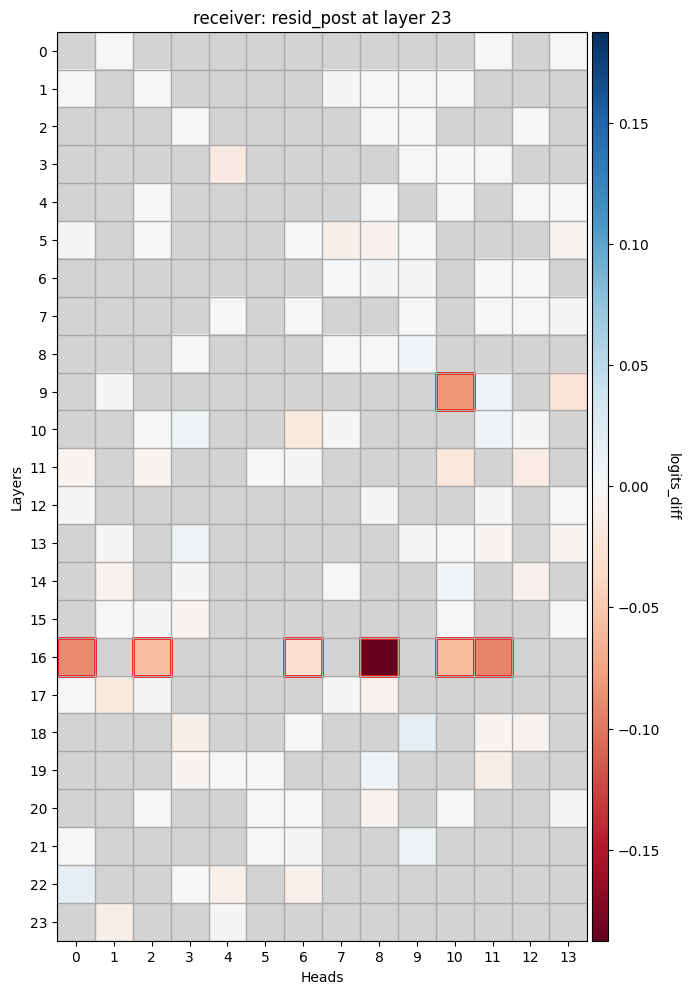

 ... (more hidden) ...
 ... (more hidden) ...


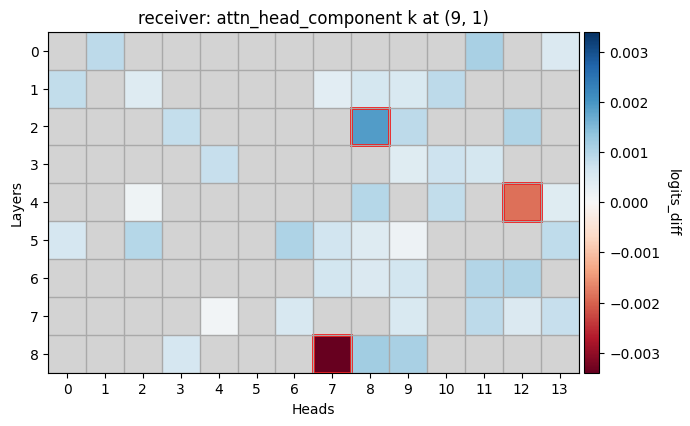

 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


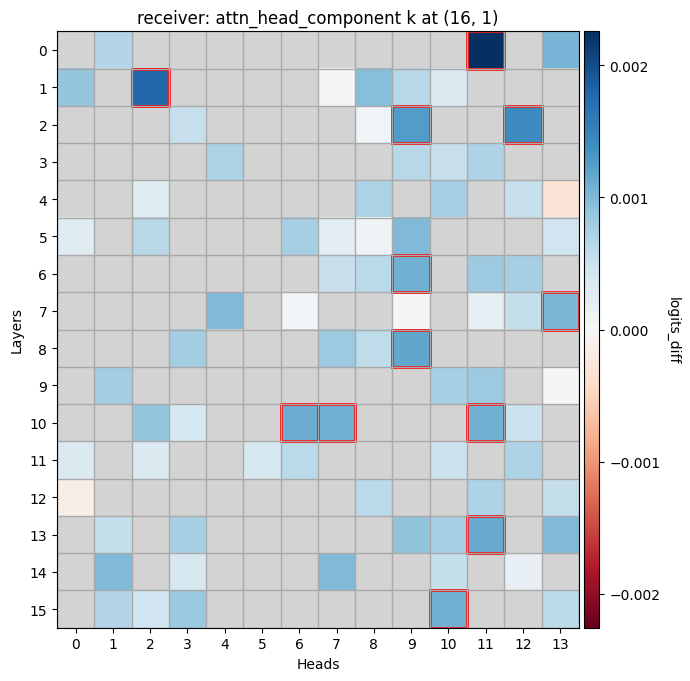

 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


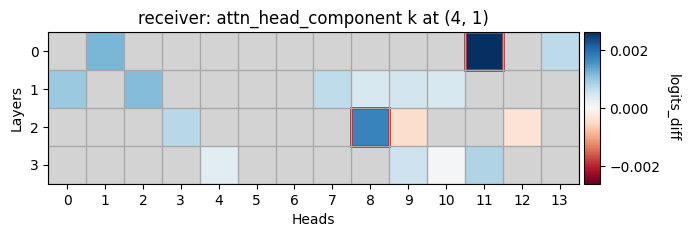

 ... (more hidden) ...
 ... (more hidden) ...


skipt zero layers (0, 11)


 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


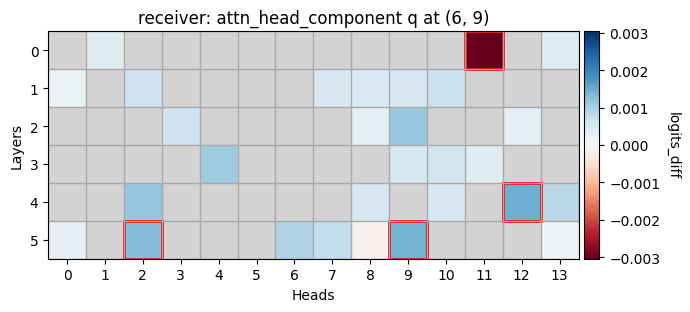

 ... (more hidden) ...


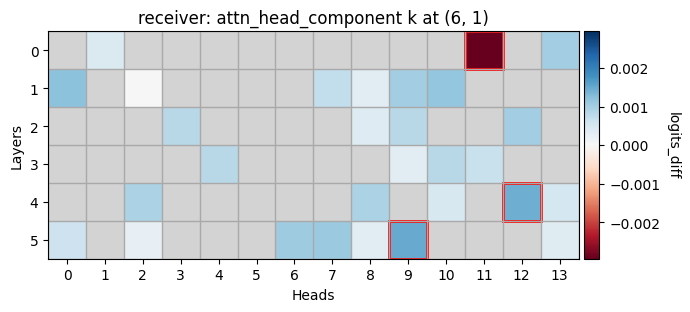

 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


skipt zero layers (0, 11)


 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


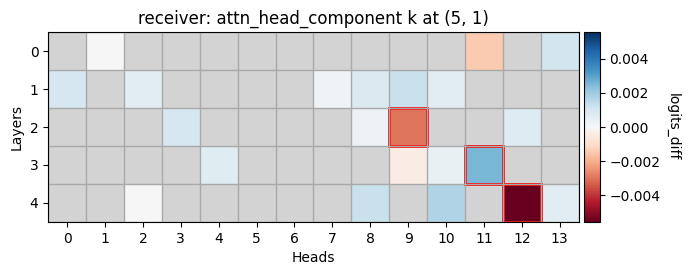

 ... (more hidden) ...
 ... (more hidden) ...


{9: [10],
 16: [0, 2, 6, 8, 10, 11],
 2: [8, 9, 12],
 4: [12],
 8: [7, 9],
 0: [11],
 1: [2],
 6: [9],
 7: [13],
 10: [6, 7, 11],
 13: [11],
 15: [10],
 5: [2, 9],
 3: [11]}

In [14]:
from Patching.contr_APP import contr_APP
gc.collect()
t.cuda.empty_cache()

#scales = [2.5, 2, 1.5, 1]
scales=[1.75]
min_activation_thresholds=[0.002]
ks = [2]
#scales = [2]

APP_CIRCUIT = contr_APP(     
    args=args,
    ks = ks, 
    scales = scales,
    min_activation_thresholds=min_activation_thresholds, 
    resid_scale=2
)
APP_CIRCUIT


In [12]:
APP_CIRCUIT

{9: [10, 11, 13, 1],
 16: [0, 2, 6, 8, 10, 11],
 2: [8, 9, 12],
 4: [12, 2, 10, 13],
 8: [7, 8, 9, 3],
 0: [11, 1],
 1: [2, 0, 9, 10, 7],
 5: [9, 2, 7, 8, 13],
 6: [9, 12, 8],
 7: [4, 13, 6, 12, 9],
 10: [6, 7, 11, 3, 12],
 13: [9, 11, 13, 10],
 14: [1, 7],
 15: [10],
 3: [11, 10, 9],
 12: [0, 11],
 11: [0, 12, 2, 5]}

## Load And Evalaute A Circuit

In [80]:
#CIRCUIT = load_circuit(subfolder, name="circuit.txt")

CIRCUIT = load_circuit("/mnt/lustre/work/eickhoff/esx670/res_final/Qwen/Qwen2.5-7B/induction/FLAP_Path_Patching/logits_diff/sqrt/min_threshold-0.0001/k_2-scale_2.5/", name= "circuit.txt")
CIRCUIT = dict(sorted(CIRCUIT.items()))
CIRCUIT_size = circuit_size(CIRCUIT=CIRCUIT)
CIRCUIT

{0: [3, 10], 21: [17], 22: [25], 23: [11, 13], 26: [22], 27: [10, 13]}

In [81]:
#CIRCUIT = load_circuit(subfolder, name="circuit.txt")

CIRCUIT = load_circuit("/mnt/lustre/work/eickhoff/esx670/res/Qwen/Qwen2.5-0.5B/ioi/path/automatic/logits_diff/sqrt/min_threshold-0.02/k_2-scale_1.5/", name= "circuit.txt")
CIRCUIT = dict(sorted(CIRCUIT.items()))
CIRCUIT_size = circuit_size(CIRCUIT=CIRCUIT)
CIRCUIT


{0: [1],
 3: [4],
 4: [12],
 5: [9],
 6: [9],
 8: [7],
 9: [13, 10],
 10: [6],
 11: [10, 12, 8],
 12: [0, 10, 11, 13, 7],
 13: [2, 3, 6, 10],
 14: [0, 3, 5, 1, 2],
 15: [7, 10, 0, 6, 13, 5],
 16: [10, 7],
 19: [6, 8, 10, 11, 4, 9],
 20: [7, 9, 12],
 21: [0, 12, 9, 1, 11, 6],
 22: [0, 6, 11, 9, 13],
 23: [2, 12]}

In [17]:
hooked_model = load_hooked_transformer(args.model_name, args.device,cache_dir=args.cache_dir)
tokenizer = load_tokenizer(args.model_name)
eval_dataset = load_dataset(
    prepend_bos=args.prepend_bos, 
    task=args.task, 
    patching_method="path",
    tokenizer=tokenizer, 
    N=200,
    device=args.device, 
    model_name=args.model_name,
    seed=args.seed+20
    )

hooked_model.reset_hooks(including_permanent=True)

with torch.no_grad():
    hooked_gt = hooked_model(eval_dataset.clean_tokens)
ave_logit_gt = ave_logit_diff(
    logits=hooked_gt, 
    correct_answers=eval_dataset.correct_answers,
    wrong_answers=eval_dataset.wrong_answers,    target_idx=eval_dataset.target_idx.to(args.device),
    task=args.task,
    model_name=args.model_name
    )

print("average logit ground truth", ave_logit_gt, "\n")

#print(f"circuit size {CIRCUIT_size}/{hooked_model.cfg.n_layers * hooked_model.cfg.n_heads}")

ave_logit_circuit, performance = evaluate_circiut(
            model=hooked_model, 
            CIRCUIT=APP_CIRCUIT,
            dataset=eval_dataset,
            ave_logit_gt=ave_logit_gt, 
            task=args.task,
            model_name=args.model_name
        )

result_text = print_statics(
    title="*********** IOI CIRCUIT FOUND BY ACCELERATED PATH PATCHING **************",
    ave_logit=ave_logit_circuit, 
    performance_achieved=performance,
    CIRCUIT=APP_CIRCUIT, 
    IOI_CIRCUIT=CIRCUIT
    )

print(result_text)

loading Qwen/Qwen2.5-0.5B as HookedTransformer
use float 16
Loaded pretrained model Qwen/Qwen2.5-0.5B into HookedTransformer
Moving model to device:  cuda
load Qwen tokenizer
loading GreaterThan dataset for Qwen/Qwen2.5-0.5B
average logit ground truth 4.250468730926514 


 
*********** IOI CIRCUIT FOUND BY ACCELERATED PATH PATCHING **************
Average logit difference: 2.8406 
circuit size: 21 
performance achieved: 66.83% 
TPR: 80.00% 
FPR: 23.81% 
Precision: 76.19% 



In [ ]:
model_mean_ablation = pp._model
model_mean_ablation.reset_hooks(including_permanent=True)
tokenizer = model_mean_ablation.tokenizer
model_mean_ablation.eval()

eval_dataset = load_dataset(prepend_bos=False, task=args.task, patching_method="path",tokenizer=tokenizer, N=20   , device=args.device)

# original gpt2 model
logits_gt = model_mean_ablation(eval_dataset.clean_tokens)
ave_logit_gt = ave_logit_diff(logits_gt, eval_dataset.answer_tokens, eval_dataset.target_idx.to(args.device))

ave_logit_circuit, performance_cicrcuit = evaluate_circiut(
    model = model_mean_ablation, 
    CIRCUIT=CIRCUIT,
    dataset=eval_dataset,
    ave_logit_gt=ave_logit_gt
    )


# Look at Attention Pattern

In [274]:
from circuits import IOI_CIRCUIT
CIRCUIT = IOI_CIRCUIT

CIRCUIT = {11: [1, 8], 
           10: [9],
           9: [7], 
           6: [0], 
           4: [3], 
           2: [6], 
           1: [4], 
           0: [4]
           
           }


The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


load gpt2 tokenizer
load gpt2 as CasualLLM
loading GenderedPronouns dataset for gpt2
Top 10 Predictions
Prompt 0 : That Person is really clever, isnt't she
 he        | Probability: 0.6005
 she       | Probability: 0.0701
 it        | Probability: 0.0689
 that      | Probability: 0.0688
 this      | Probability: 0.0223
 his       | Probability: 0.0167
 there     | Probability: 0.0162
 the       | Probability: 0.0096
 He        | Probability: 0.0078
 they      | Probability: 0.0074


Top 10 Predictions
Prompt 0 : So Anna is really clever, isnt't she
 she       | Probability: 0.8612
 it        | Probability: 0.0693
 that      | Probability: 0.0129
 her       | Probability: 0.0115
 there     | Probability: 0.0098
 he        | Probability: 0.0082
 this      | Probability: 0.0039
 the       | Probability: 0.0016
 She       | Probability: 0.0013
.          | Probability: 0.0008


from 0 to 10


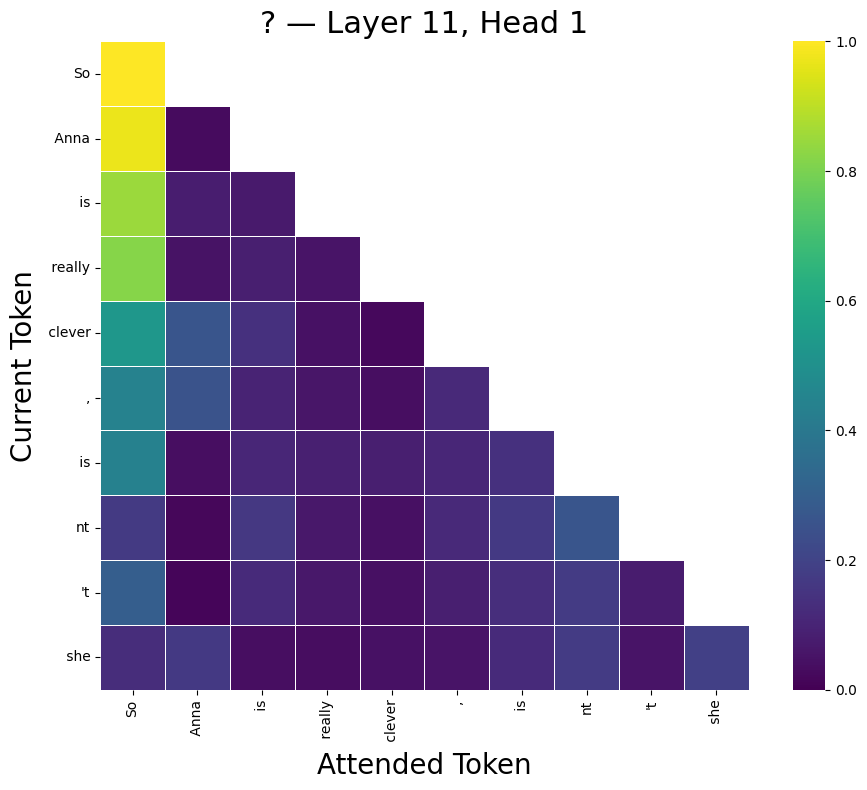

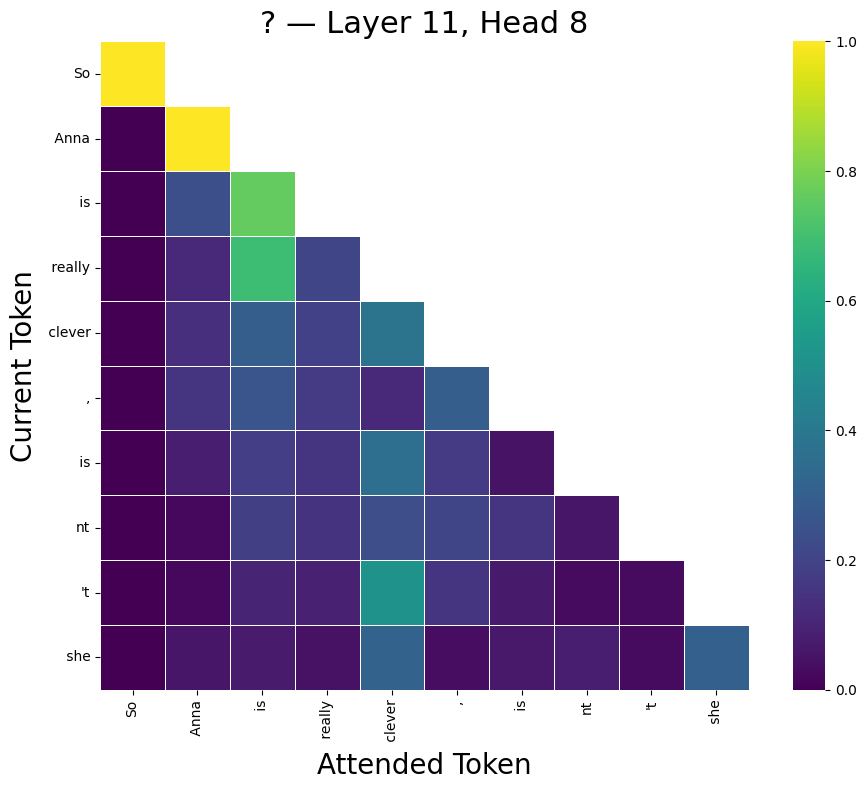

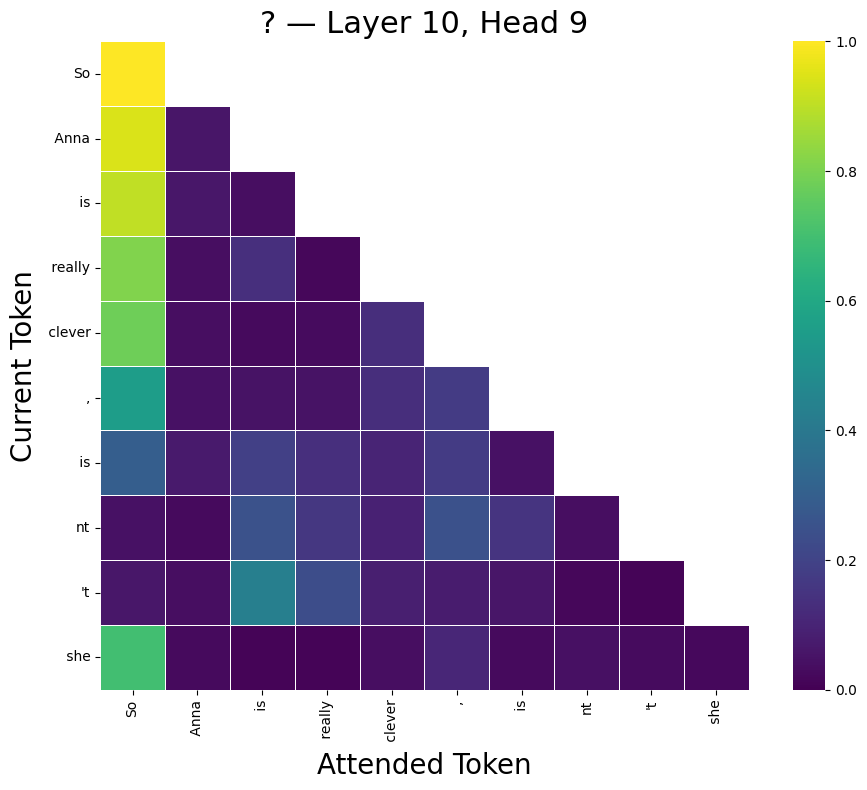

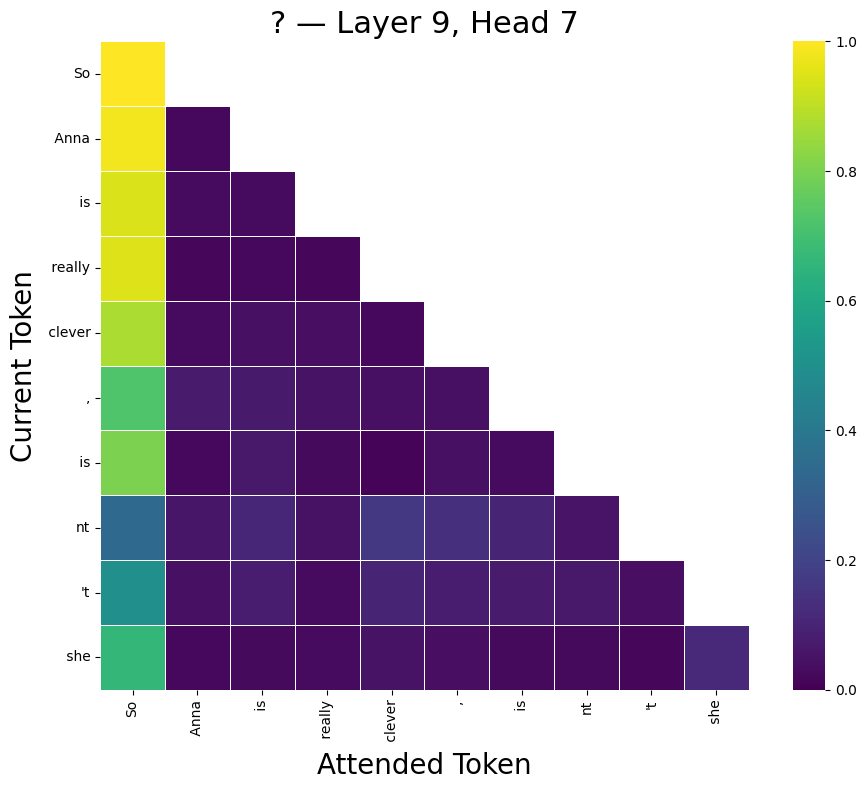

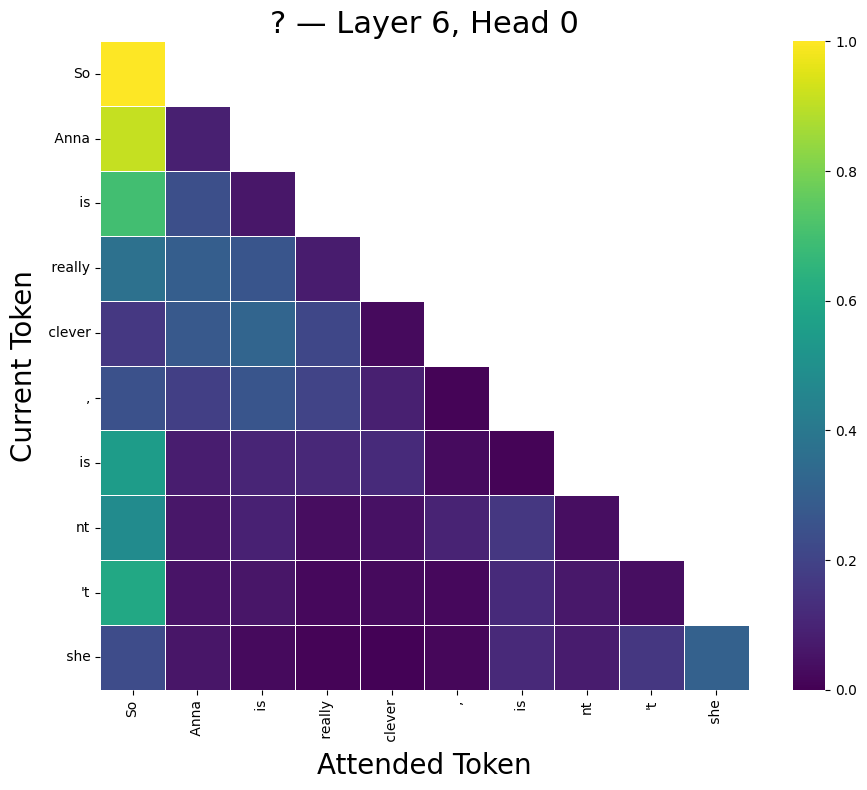

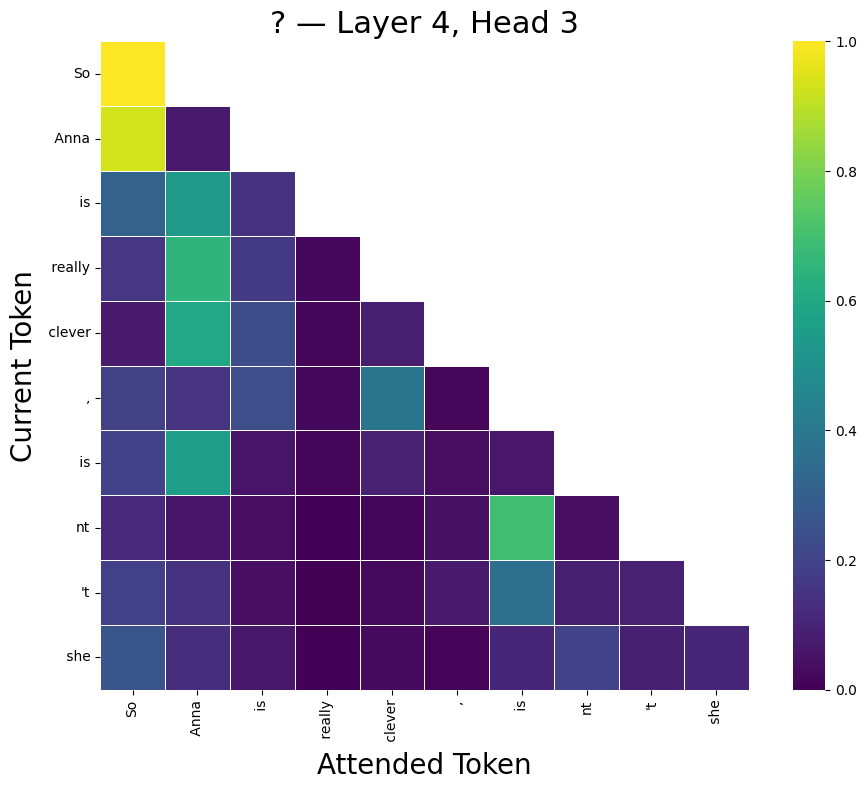

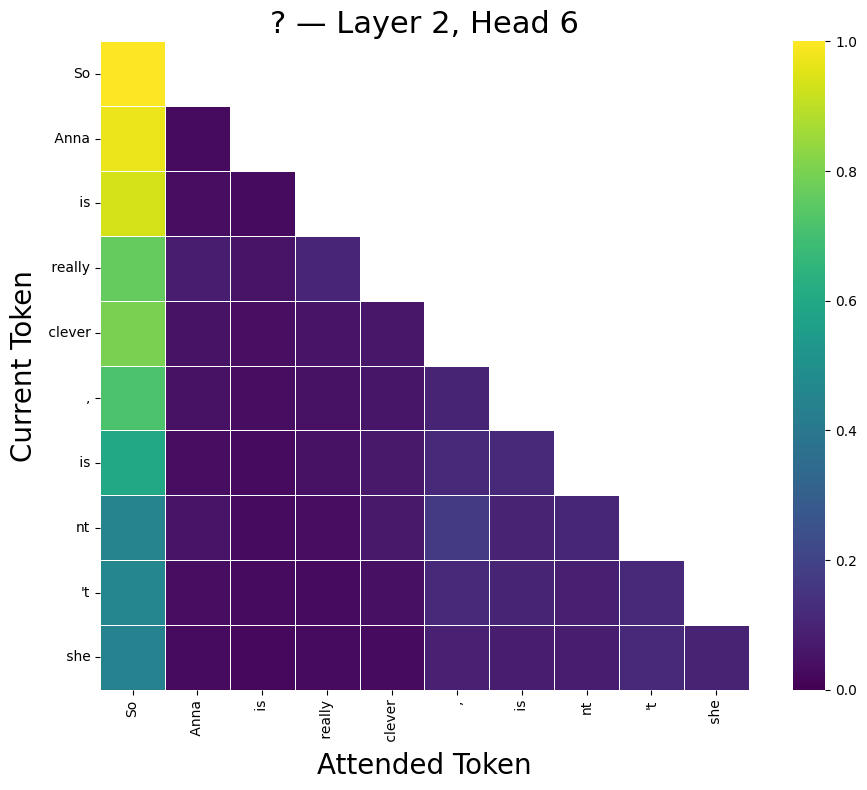

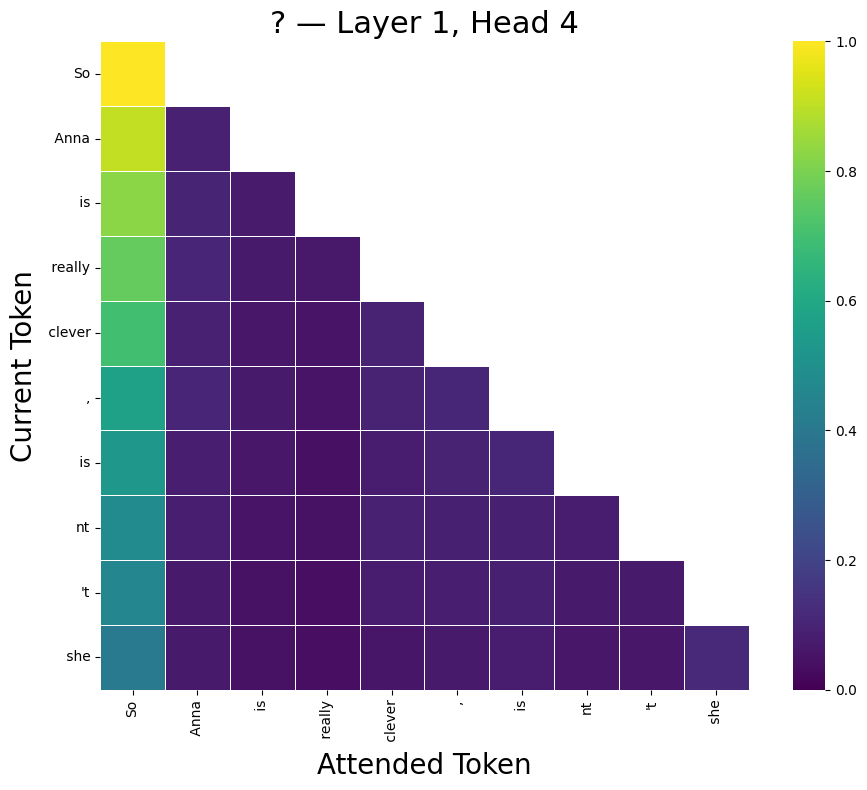

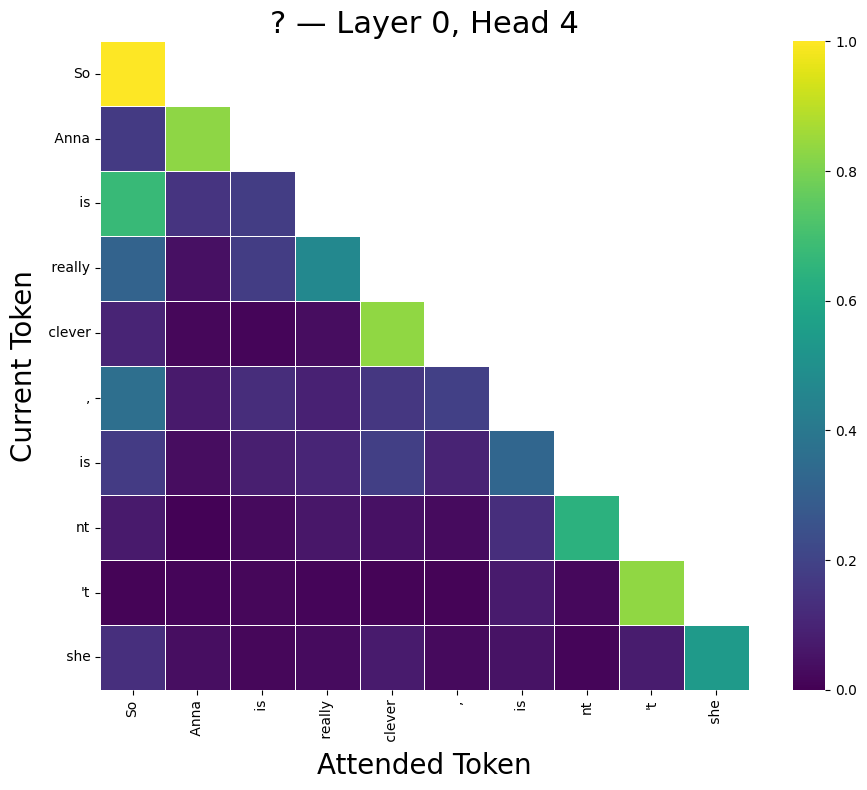

In [279]:
from utils.utils import activation_patterns

tokenizer = load_tokenizer(args.model_name)

model = load_transformer(args.model_name, output_attentions=True)
#model=load_hooked_transformer(args.model_name, device=args.device)
args.prepend_bos =False
dataset = load_dataset(
    args.task, 
    tokenizer,
    N =1, 
    seed=20, 
    device=args.device, 
    model_name=args.model_name, 
    prepend_bos=False, 
    remove_target_token=False
)
predict_target_token(model_hooked, dataset, eval_tokenizer, device=args.device, n=1, use_corrupted=True)

predict_target_token(model_hooked, dataset, eval_tokenizer, device=args.device, n=1, use_corrupted=False)


# ----- activation patterns of all elements in a circuit -----
#activation_patterns(model=model, tokenizer=tokenizer, dataset=dataset, CIRCUIT=CIRCUIT)

# ----- activation patterns of specific layer and head elements -----
activation_patterns(
    model=model, 
    tokenizer=tokenizer,
    dataset=dataset,
    CIRCUIT=CIRCUIT,
    activation_type="clean", #"clean", "corrupted", "difference"
    save=False,
    show=True,
    out_path=f"{args.out_path}/{args.model_name}/{args.task}",
    title="?"
    
    
    ) #layer_list=[14] , head_list=[3], is_corrupted=True)